C:\Users\HP\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Epoch 1/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 86s 912ms/step - accuracy: 0.5592 - loss: 1.9384 - val_accuracy: 0.9958 - val_loss: 0.0209
Epoch 2/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 79s 876ms/step - accuracy: 0.9952 - loss: 0.0309 - val_accuracy: 0.9930 - val_loss: 0.0306
Epoch 3/3
90/90 ━━━━━━━━━━━━━━━━━━━━ 84s 934ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9958 - val_loss: 0.0133


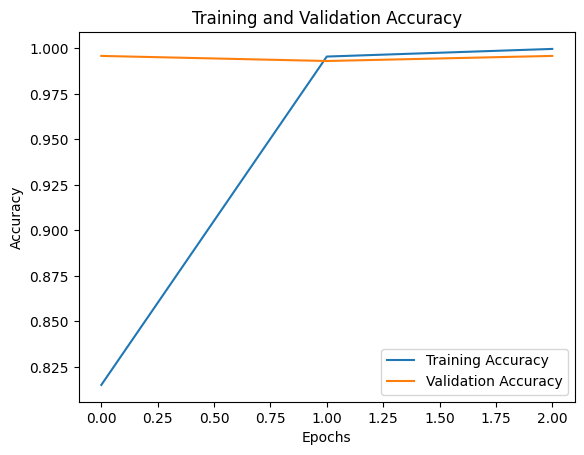

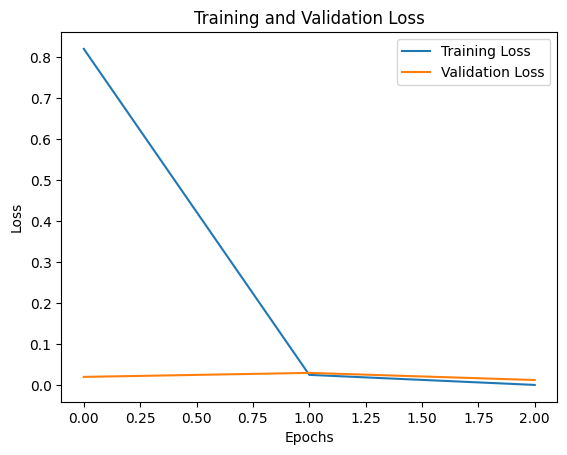

In [2]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
import joblib
import matplotlib.pyplot as plt

# Path to dataset
data_dir = "Data"

# Parameters
img_size = 300  # Image size (300x300)
batch_size = 32
epochs = 3  # Adjust as needed
patience = 3  # Early stopping patience

# Preprocess dataset
def load_data(data_dir, img_size):
    data = []
    labels = []
    
    # Only include folders from A to Z
    alphabet_folders = [chr(i) for i in range(ord('A'), ord('Z') + 1)]

    for folder in alphabet_folders:
        folder_path = os.path.join(data_dir, folder)
        if os.path.isdir(folder_path):
            for img_name in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_name)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (img_size, img_size))  # Resize image
                    data.append(img)
                    labels.append(folder)  # Folder name is the label

    # Convert data to numpy arrays
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

# Load the data
X, y = load_data(data_dir, img_size)

# Normalize image data
X = X / 255.0

# Binarize labels (convert labels to one-hot encoded format)
lb = LabelBinarizer()
y = lb.fit_transform(y)

# Save the label binarizer for later use
joblib.dump(lb, "label_binarizer.pkl")

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),

    Dropout(0.5),  # Dropout to prevent overfitting

    Dense(128, activation='relu'),
    Dense(26, activation='softmax')  # 26 output neurons for 26 classes (A-Z)
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=patience)

# Train the model and store training history
history = model.fit(X_train, y_train, 
                    validation_data=(X_test, y_test), 
                    epochs=epochs, 
                    batch_size=batch_size, 
                    callbacks=[early_stop])

# Save the trained model
model.save("TRhand_gesture_model_A_Z.h5")

# Plot training accuracy and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
